# Práctica: People Name Disambiguation
## Búsqueda y Recuperación de Información
## Autores: 
     Raúl Sánchez Martín
     Ignacio Arias Barra

## Índice

1) Introducción

2) Requisitors previos

3) Punto de partida

4) Modificaciones propuestas

    4.1) Modificaciones individuales
    
    4.2) Combinaciones
    
5) Ejecución del programa completo

6) Evaluación de resultados

7) Conclusiones

## 1. Introducción

La presente práctica se desarrolla dentro de la asignatura de *Búsqueda y Recuperación de Información* del *Máster en Data Science* de la Universidad Rey Juan Carlos. Inicialmente, se disponen de 19 textos correspondientes a 4 personas diferentes, todas ellas llamadas *Thomas Baker*. El objetivo de la presente práctica consiste en agrupar dichos textos en diferentes *clústers* intentado obtener que, en cada uno de ellos, sólo aparezcan textos referentes a la misma persona. A lo largo de la práctica se van a proponer e implementar diferentes representaciones de los textos, estudiando el efecto que tiene cada propuesta en el resultado final. Dado que la agrupación fidedigna de los textos es conocida, se va a poder evaluar la exactitud de cada mejora propuesta.

La estructura del presente documento es como sigue. Después de la Introducción, se especifican los requisitos previos necesarios para poder ejecutar los códigos propuestos. A continuación, se describe el punto de partida así proporcionado en el propio enunciado de la práctica. Posteriormente, se describen todas las diferentes  opciones propuestas para la representación de los textos, incluyendo posibles combinaciones de las mismas. Después, se incluyen todos los comandos necesarios para la ejecución de las propuestas anteriormente descritas. Una vez que ya se han obtenido todos los resultados, se procede a su evaluación. Finalmente, se incluyen unas conclusiones.

## 2. Requisitos previos

La presente práctica se realizará utilizando `Python 3.5`. Además de un importante número de librerías de Python ya preinstaladas, también se hará uso de las librerías `nltk`, `sklearn` `matplotlib` y `seaborn`, las cuales han de ser instaladas en nuestro entorno `Python` de manera específica. Por otro lado, la librería `nltk` utiliza una serie de archivos cuya ruta ha de ser espcificada, para cada máquina, por medio de la variable `path_to_apend`, en el código incluido más abajo. Finalmente, se hará uso del [Stanford Named Entity Recognizer](https://nlp.stanford.edu/software/CRF-NER.shtml). Esta librería, implementada en *Java*, es capaz de realizar reconocimientos de entidades de una manera óptima. Para su correcto funcionamiento, se ruega al lector que configura su máquina tal y como se especifica en el siguiente link: [Configuring Stanford Parser and Stanford NER Tagger with NLTK in python on Windows and Linux](https://blog.manash.me/configuring-stanford-parser-and-stanford-ner-tagger-with-nltk-in-python-on-windows-f685483c374a). A continuación, se incluye el fragmento de código responsable de la importación de todas las librerías necesarias para el resto de la práctica.


In [1]:
# -*- coding: utf-8 -*-
# Importing libraries
import re, pprint, os, numpy
import nltk
from nltk import ngrams
#import goslate
from nltk.collocations import *
import string
from nltk.corpus import stopwords
path_to_append = '/media/nacho/f8371289-0f00-4406-89db-d575f3cdb35e/Master/Trimestre 2/RIM/nltk_data'
path_to_append = '/media/raul/Data/nltk_data'
path_to_append = '/home/raul/nltk_data'
nltk.data.path.append(path_to_append)
from sklearn.metrics.cluster import *
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from nltk.cluster import GAAClusterer
from sklearn.metrics.cluster import adjusted_rand_score
from nltk.corpus import stopwords
import operator
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings('ignore')
from nltk.tag import StanfordNERTagger
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
import csv   
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## 3. Punto de partida

Como se indica en el propio enunciado de la práctica, no se parte desde cero sino que parte del código inicial para la ejecución de la presente práctica ya ha sido proporcinado. En concreto, se incluyen tres funciones:

    1) read_file: Función utilizada para la lectura de los textos. Esta función no ha sido modificada.
    
    2) TF: Función utilizada para la vectorización de un texto. Esta función no ha sido modificada.

    3) cluster_texts: Función que, dado una colección de textos, en primer lugar los vectoriza y posteriormente los agrupa utilizando diferentes algoritmos de clustering. Esta función ha sido modificada respecto a la proporcionada inicialmente para poder elegir que algorítmo de clustering se utiliza.
    


In [2]:
def read_file(file):
    """
    Function to read a file, whose path is specified by 
    the input "file".
    """
    myfile = open(file,"r")
    data = ""
    lines = myfile.readlines()
    for line in lines:
        data = data + line
    myfile.close
    return data

def TF(document, unique_terms, collection):
    """
    Function to create a TF vector for one document which belongs to 
    to a collection. For each of our unique words, we have a feature 
    which is the tf for that word in the current document. The
    following imputs must be specified:
        *) document: the document to study
        *) collection: collection to which that document belongs
        *) unique_terms: unique terms of the collection
    """
    word_tf = []
    for word in unique_terms:
        word_tf.append(collection.tf(word, document))
    return word_tf

def cluster_texts(texts, clustersNumber, distanceFunction, clusterMode):
    """
    Function to cluster several texts. The following inputs must be 
    specified:
        *) texts: collection of texts to cluster
        *) clustersNumber: number of clusters to be used
        *) distanceFunction: distance function to be used by the 
           clustering algorithms
        *) clusterMode: cluster mode to be used:"AgglomerativeClustering",
           "KMeans" or "MiniBatchKMeans", all of them belonging to the 
           scikit-learn library
           
    """

    collection = nltk.TextCollection(texts)    
    # print("Created a collection of", len(collection), "terms.")
    
    # Get a list of unique terms
    unique_terms = list(set(collection))
    # print("Unique terms found: ", len(unique_terms))

    ### And here we actually call the function and create our array of vectors.
    # TF mide la frecuencia en los textos.
    # Mira de los terminos unicos, cuantas veces aparece en el documento. No mira cuantas veces aparece en la coleccion
    # Hay otras medidas, como TF-IDF que son mas precisas porque tambien miran cuantas veces aparece en la coleccion
    vectors = [numpy.array(TF(f,unique_terms, collection)) for f in texts]
    # print("Vectors created.")
    # print(vectors)
    
    # for vector in vectors:
        # print("Vector ", len(vector))

    # initialize the clusterer
    # clusterer = GAAClusterer(clustersNumber)
    # clusters = clusterer.cluster(vectors, True)
    # Estas lineas siguientes comentadas es lo mismo pero con otra libreria, la llamada scikit-learn
    
    if clusterMode == "AgglomerativeClustering":
    
        clusterer = AgglomerativeClustering(n_clusters=clustersNumber,
                                         linkage="average", affinity=distanceFunction)
        clusters = clusterer.fit_predict(vectors)
    
    elif clusterMode == "KMeans":
    
        clusterer = KMeans(n_clusters=clustersNumber, random_state=0)
        clusters = clusterer.fit(vectors).predict(vectors)
        
    elif clusterMode == "MiniBatchKMeans":
        
        clusterer = MiniBatchKMeans(n_clusters=clustersNumber, random_state=0)
        clusters = clusterer.fit(vectors).predict(vectors)
    else:
        print("Invalid cluster mode")
        return None

    return clusters


Utilizando las tres funciones anteriormente descritas, en el enunciado de la propia práctica se realiza un clustering inicial de los textos cuyo resultado ha sido guardado bajo la clave `primitive`.

## 4. Modificaciones propuestas

A continuación se van a detallar todas y cada una de las diferentes representaciones propuestas en la presenta práctica. Por un lado, se explicará cada una de ellas y se justificará el efecto esperado. Además, también se ha tenido en cuenta diferentes combinaciones de las mismas. 

Dado que para ciertas transformaciones de texto es necesario saber a priori el lenguaje del mismo, se ha implementado la función `get_language`, implementada de acuerdo al siguiente fragmento de código:

In [3]:
def get_language(possible_lan, text):
    """
    Function that returns the language of a text. The following
    inputs must be specified:
        *) text: text to be analyzed
        *) possible_lan: list of possible languages
            +) "EN":english
            +) "ES":spanish
    More info in: http://blog.alejandronolla.com/2013/05/15/detecting-text-language-with-python-and-nltk/
    """
    languages_score = {}
    for language in possible_lan:
        stopwords_set = set(stopwords.words(language))
        words_set = set(text)
        common_elements = words_set.intersection(stopwords_set)
        languages_score[possible_lan[language]] = len(common_elements)
    return max(languages_score.items(), key=operator.itemgetter(1))[0]

Otra función que se ha utilizado en diferentes ocasiones a lo largo de la presente práctica es `delete_words_from_text`. Dicha función, desarrollada en el fragmento de código de abajo, elimina de un texto inicial todas las palabras espeficiadas.

In [4]:
def delete_words_from_text(text, words_to_delete):
    """
    Function that filters a initial text excluding all
    the words specified in the list "words_to_delete"
    """
    words_to_include = []
    words_to_delete = [word.lower() for word in words_to_delete]
    
    for word in text:
        if word.lower() not in words_to_delete:
            words_to_include.append(word)
            
    return words_to_include

### 4.1 Modificaciones individuales
#### 4.1.1 Filtrado por tipo de palabras
Esta modificación permite filtrar un texto inicial e incluir en la salida sólo unos tipos de palabra determinado. Por ejemplo, se especificará que sólo se incluyan sustantivos, adjetivos, advervios, etc. Es esperable que los sustantivos tengan más efecto a la hora de clasificar los textos que los artículos o adjetivos. Por ello, se espera que se mejore la solución inicial. Esta transformación implementado por medio de las funciones `get_named_entities_1` y `get_named_ent_txts_1`, y sus resultados han sido guardados utilizando la clave `identity_analysis_1`.

In [5]:
def get_named_entities_1(initial_document, selected_types):
    """
    Function that filters a initial document only including
    that words specified in the variable "selected_types".
    """
    named_entities = list()
    selected_entities = list()
    try:
        for sentence in initial_document:
            tokenized_sentence = nltk.word_tokenize(sentence)
            # tagged_sentence = nltk.pos_tag(tokenized_sentence)
            tagged_sentence = nltk.pos_tag(tokenized_sentence, tagset= 'universal')
            named_ent = nltk.ne_chunk(tagged_sentence, binary=False)
            named_entities.append(named_ent)

        for element in named_entities:
            word = element.pos()[0][0][0]
            type_word = element.pos()[0][0][1]
            if type_word in selected_types:
                selected_entities.append(word)
        
        return selected_entities
    
    except Exception as e:
        print(str(e))
        
def get_named_ent_txts_1(raw_texts):
    """
    Function that applies the function "get_named_entities_1"
    to a collection of texts "raw_texts"
    """
    named_ent_txts_1 = []
    for text in raw_texts:
        curr_named_ent = get_named_entities_1(text, types_included_1)
        text_to_append = nltk.Text(curr_named_ent)
        named_ent_txts_1.append(text_to_append)
    return named_ent_txts_1

#### 4.1.2 Entidades nombradas NLTK
En este caso, se prone la transformación por medio de la cual sólo se incluyan las entidades nombradas obtenidas utilizando la librería `NLTK`. Se espera una mejora respecto a la solución inial ya que las entidades nombradas, que pueden ser lugares, organizaciones, etc...tienen mucho más peso a la hora de discernir entre diferentes textos que por ejemplo los artículos o conjunciones. Estos últimos tipos de palabras, pueden ser compartidas sin ningún problema entre textos de personas totalmente diferentes. La implementación de esta transformación se ha realizado a través de las funciones `get_named_entities_2` y `get_named_ent_txts_2`, y los resultados finales se han sido guardados utilizando la clave `identity_analysis_2`.

In [6]:
def get_named_entities_2(initial_document):
    """
    Function that filters a document ("initial_document") only including
    the recognized named entities using the capabilities of
    the NLTK library.
    """
    named_entities = list()
    selected_entities = list()
    try:
        for sentence in initial_document:
            tokenized_sentence = nltk.word_tokenize(sentence)
            tagged_sentence = nltk.pos_tag(tokenized_sentence)
#             tagged_sentence = nltk.pos_tag(tokenized_sentence, tagset= 'universal')
            named_ent = nltk.ne_chunk(tagged_sentence, binary=False)
            named_entities.append(named_ent)
        
        for element in named_entities:
            if hasattr(element[0], 'label') and element[0].label:
                selected_entities.append(element[0].leaves()[0][0])
        
        return selected_entities 
    
    except Exception as e:
        print(str(e))

def get_named_ent_txts_2(raw_texts):
    """
    Function that applies the function "get_named_entities_2"
    to a collection of texts "raw_texts"
    """
    named_ent_txts_2 = []
    for text in raw_texts:
        curr_named_ent = get_named_entities_2(text)
        text_to_append = nltk.Text(curr_named_ent)
        named_ent_txts_2.append(text_to_append)
    return named_ent_txts_2

#### 4.1.3 Entidades nombradas Stanford NER

Esta transformación es la misma que la realizada en la sección 4.1.3, pero utilizando el [Stanford Named Entity Recognizer](https://nlp.stanford.edu/software/CRF-NER.shtml) en vez de la librería `NLTK`. 

In [7]:
def get_entities_standorf(sample, types_named_entities):
    """
    Function that filters a document ("initial_document") only including
    the recognized named entities using the capabilities of
    the Stanford NER.
    """
    # Select the first classifier model
    stanford_classifier = os.environ.get('STANFORD_MODELS').split(':')[2]

    # Get the path for the StandorfNERTagger
    stanford_ner_path = os.environ.get('CLASSPATH').split(':')[0]
    
    st = StanfordNERTagger(stanford_classifier, stanford_ner_path, encoding='utf-8')
    result_named_entities = st.tag(sample.split())
    filtered_named_entities = []

    for item in result_named_entities:
        word, entity = item
        if entity in types_named_entities:
#             filtered_named_entities.append((word, entity))
            filtered_named_entities.append(word)
        
    return filtered_named_entities


def get_named_ent_txts_3(raw_texts, types_named_entities):
    """
    Function that applies the function "get_entities_standorf"
    to a collection of texts "raw_texts"
    """
    named_ent_txts_3 = []
    for text in raw_texts:
        curr_named_ent = get_entities_standorf(text, types_named_entities)
        text_to_append = nltk.Text(curr_named_ent)
        named_ent_txts_3.append(text_to_append)
    return named_ent_txts_3


#### 4.1.4 Exclusión de palabras vacías

La siguiente transformación consiste en la eliminación de las palabras vacías de un texo. Definimos palabras vacías a palabras propias del léxico que en principio no tienen un significado, como determinantes, artículos, etc. Se espera una mejora respecto al resultado inicial ya que estas palabras vacías, que por razones propias del lenguaje pueden estar presentes en textos que no tengan ninguna relación, pueden crear conexiones entre textos que en realidad no están relacionados. Para la implementación de esta transformación, se han utilizado las dos funciones `get_language` y `delete_words_from_text` desarrolladas con anterioridad en combinación con la función `get_texts_no_stop_words`, incluida en el fragmento de código de abajo. Los resultados de esta transformación se guardarán bajo la clave `no_stop_words`.

In [8]:
def get_texts_no_stop_words(raw_texts):
    """
    Function that deletes the stop words of a collection
    of texts included in the variable "raw_texts"
    """
    filtered_texts = []
    for text in raw_texts:
        language = {'en':'english', 'es':'spanish'}[get_language(possible_lan, text)]
        words_to_exclude = list(set(stopwords.words(language)))
        curr_filtered_text = delete_words_from_text(text, words_to_exclude)
        filtered_texts.append(nltk.Text(curr_filtered_text))
    return filtered_texts  

#### 4.1.4 Exclusión del nombre Thomas Baker
Es lógico que las palabras "Thomas" y "Baker" puedan estar presentes en todos los textos, ya que aunque se refierent a 4 personas diferentes, todas ellas comparten el nombre Thomas Baker. Está claro que ambas palabras van a conectar textos que pueden estar o no relacionados. En este último caso, puede llevar a confusiones. Por ello, se espera que la eliminación de ambas palabras mejore de manera notoria la diferenciación entre los diferentes textos. Para ello, se ha hecho uso de la función `delete_words_from_text` junto con la función `get_texts_exclude_tomas_baker`, implementada en el código de abajo. Los resultados han sido recogidos bajo la clave `no_tomas_baker`.

In [9]:
def get_texts_exclude_tomas_baker(raw_texts):
    """
    Function that deletes the words "Thomas" and "Baker" 
    of a collection of texts included in the variable "raw_texts"
    """
    filtered_texts = []
    for text in raw_texts:
        curr_filtered_text = delete_words_from_text(text, ['Thomas', 'Baker'])
        filtered_texts.append(nltk.Text(curr_filtered_text))
    return filtered_texts

#### 4.1.5 Utilización de N-gramas
En esta sección, se propone representar los textos por medio de N-gramas. Definimos N-grama como una tupla de N palabras pertenecientes al texto, escogidas teniendo en cuenta la posición entre ciertas palabras del texto y que puede que representen un concepto único. Puesto que el significado de una palabra viene mejor determinado por las palabras que están a su alrededor, la utilizadión de esta técnica nos va ayudar a detectar textos que puedan explicar conceptos parecidos y por lo tanto a la clusterización de los textos. Por ello, se espera una mejora respecto a la solución inicial. En la presente práctica se han tenido en cuenta tanto bigramas como trigramas. La función utilizada para esta transformación es `get_ngram` y los resultados han sido guardados bajo la clave `bigrams`, para los bigramas, y `trigrams`, para los tigramas.

In [10]:
def get_ngram(raw_texts, ngramlimit):
    ngramlist=[]
    for text in raw_texts:
        ngram_text = nltk.ngrams(text, ngramlimit)
        ngramlist.append(nltk.Text(ngram_text))
    return ngramlist           

#### 4.1.6 Stemming
La siguiente transformación propuesta consiste en obtener la raiz de cada palabra, proceso denominado *stemming*. Este proceso puede ayudar a conectar textos que están relacionados. Por ejemlo, imaginemos que dos textos versan sobre un cantante. Es probable que aparezcan palabras tales como *música* o *musical*. Sin realizar ninguna transformación, para el algoritmo utilizado en la presente práctica, ambas palabras son diferentes y no guardan relación. Sin embargo, está claro que ambas palabras parten de la misma raiz y además están muy relacionadas. Analizando solo las raizes, llegaríamos a la conclusión de que ambas palabras son la "misma". Para la implementación de esta transformación, se han utilizado las funciones `stemming_2` y `get_stemmed_txts_2` descritas en el código de abajo, incluyendo los resultados bajo la clave `stemmed_txts`.

In [11]:
def stemming_2(text, lan='en'):
    """
    Function that "stems" a text.
    """
    stemmeds = []
    if lan == 'en':
        # Steamer ingles
        stemmer = PorterStemmer()        
    elif lan == 'es':
        # Stemer espanol        
        stemmer = SnowballStemmer("spanish")
        
    # Para cada token del texto obtenemos su raíz.
    for word in text:
        stemmed = stemmer.stem(word)
        stemmeds.append(stemmed)
    # Escribimos el resultado para compararlo con las palabras originales.
    return stemmeds

def get_stemmed_txts_2(raw_texts):
    """
    Function that applies the function "stemming_2"
    to a collection of texts "raw_texts"
    """
    stemmed_txts = []
    for text in raw_texts:
        language = get_language(possible_lan, text)
        stemmed_txt = stemming_2(text, language)
        text = nltk.Text(stemmed_txt)
        stemmed_txts.append(text)
    return stemmed_txts

#### 4.1.7 Eliminación de palabras repetidas
A través de esta transformación, lo que se pretente es dejar los textos con palabras únicas, de tal forma que no influya cuántas veces se repitan o no un determinado grupo de ellas. Podría decirse que comparamos el *“esqueleto”* o *”esquema”* del texto. Para ello, utilizamos la función `delete_repWords_stopWords` descrita en el código de abajo y guardamos los resultados bajo la clave `no_repeated_words`.

In [12]:
def delete_repWords_stopWords(raw_texts):
    """
    Function that deletes the repeated words of 
    all the texts included in the collection "raw_texts"
    """
    deleted_repeated = []
    for text in raw_texts:
        delete_repeated_texts = []
        text = [w.lower() for w in text]  
        unique_terms = list(set(text))
#         print("Número de palabras del texto: ",str(len(text)))
#         print("Tamaño del vocabulario filtrado: ", str(len(unique_terms)))
        deleted_repeated.append(nltk.Text(unique_terms))    
    return deleted_repeated

#### 4.1.8 Lematización

La siguiente técnica utilizada, será la lematización de los textos. Lematizar consiste en encontrar el lema de cada palabra, es decir, la unidad mínima de significado de las mismas. Obteniendo estas unidades, se puede realizar una clusterización que agrupe textos que expliquen temas parecidos, obteniendo esa explicación a partir de lemas iguales. Por ello, se espera una mejora importante en comparación con la solución inicial. Para realizar esta transformación, se hace uso de la clase `SpanishLemmatizer` (sólo para textos en castellano) y la función `lemmatize_texts`, ambas especificadas en el fragmento de código de abajo. Los resultados obtenidos con la presente transformación han sido guardados bajo la clave `lemmatized`.

In [13]:
class SpanishLemmatizer():
    # Abrimos el fichero donde tenemos la información para cada palabra y lo cargamos en un diccionario.
    def __init__(self):
        with open('./Lemmatizer/lemmatization-es.txt', 'r', encoding="utf8") as f:
            self.lemma_dict = {}
            for line in f:
                if line.strip(): # Evitamos posibles líneas en blanco.
                    value, key = line.split(None, 1) # Nos quedamos con los valores clave y valor.
                                                     # None implica espacio en blanco.
                    key = key.rstrip() # Limpiamos la línea para evitar los caracteres de salto \n ó \r.
                    self.lemma_dict[key] = value
                    self.lemma_dict[value] = value  # Añadimos por si acaso también el valor como clave.

    # Obtenemos el lemma para la palabra solicitada si es que se dispone de él. En caso contrario devuelve la palabra.
    # Útil en los casos en los que no se haya aplicado un tratamiento previo del texto (stopwords y puntuación).
    def lemmatize(self,word):
        try:
            lemma = self.lemma_dict[word.lower()]
        except KeyError:
            lemma = word
        return lemma

def lemmatize_texts(raw_texts, possible_lan):
    nlemmas_texts = []
    for text in raw_texts:
        language = get_language(possible_lan, text)
        if language== 'en':
            # Seleccionamos el lematizador.
            wordnet_lemmatizer = WordNetLemmatizer()
            # Obtenemos los tokens de las sentencias.
#             tokens = nltk.word_tokenize(text)
            
            lemmatizeds = []
            nlemmas = []

            for token in text:                
                lemmatized = wordnet_lemmatizer.lemmatize(token)
                lemmatizeds.append(lemmatized)
                #print('token ',token)
                #print('lema ',lemmatized)
                # Obtenemos los lemmas consultando la base de datos de WordNet.
                list = wordnet.synsets(token)
                # Si encontramos alguna palabra relacionada obtenemos sus lemas y nos quedamos con el primero.
                if len(list) >= 1:
                    lemma = list[0].lemma_names('eng')
                    if len(lemma) > 1:
                        nlemmas.append(lemma[0])
                    else:
                        nlemmas.append((token))
                # En caso contrario simplemente introducimos en la solución la palabra actual.
            else:
                nlemmas.append(token)
            nlemmas_texts.append(nltk.Text(nlemmas))
        elif language== 'es':
            lemmatizer = SpanishLemmatizer()

            # Obtenemos los tokens del texto.
#             tokens = nltk.word_tokenize(text)            
            nlemmas = []
            lemmatizeds = []
            for token in text:                
                # Obtenemos los lemmas consultando el archivo de lemmas.
                lemmatized = lemmatizer.lemmatize(token)
                #print('token ',token)
                #print('lema ',lemmatized)
                lemmatizeds.append(lemmatized)
                # Obtenemos los lemmas consultando la base de datos de WordNet.
                list = wordnet.synsets(token, lang='spa')
                # Si encontramos alguna palabra relacionada obtenemos sus lemas y nos quedamos con el primero.
                if len(list) >= 1:
                    lemma = list[0].lemma_names('spa')
                    if len(lemma) >= 1:
                        nlemmas.append(lemma[0])
                    else:
                        nlemmas.append(token)
                # En caso contrario simplemente introducimos en la solución la palabra actual.
                else:
                    nlemmas.append(token)
            nlemmas_texts.append(nltk.Text(nlemmas))
        else:
            print('Lenguaje no reconocido')
    return nlemmas_texts

### 4.2 Combinaciones

Además de las transformaciones individuales mencionadas anteriormente, también se pueden combinar para obtener mejores resultados. En concreto, se han probado las siguientes combinaciones:

    * Exclusión del nombre Thomas Baker + Stemming, guardando los resultados bajo la clave no_tomas_stemmed
    
    * Exclusión del nombre Thomas Baker + Stemming + Exclusión de palabras vacías, guardando los resultados bajo la clave no_tomas_stemmed_no_stop
    
    * Exclusión del nombre Thomas Baker + Stemming + Filtrado por tipo de palabras, guardando los resultados bajo la clave no_tomas_stemmed_ent1
    
    *  Entidades nombradas NLTK + Exclusión del nombre Thomas Baker, guardando los resultados bajo la clave named_ent_2_no_tomas_barker
    
    * Entidades nombradas Stanford NER + Exclusión del nombre Thomas Baker, guardando los resultados bajo la clave stanford_ner_no_thomas_baker

## 5. Ejecución del programa completo
A continuación se procede a la ejecución del programa principal, evaluando las diferentes transformaciones propuestas.

### 5.1. Lectura de los textos iniciales
El primer paso consiste en la lectura de los datos iniciales, proceso que se lleva a cabo por medio del siguiente fragmento de código:

In [14]:
# Folder with all texts
folder = "Thomas_Baker"
# gsObj=goslate.Goslate()
types_named_entities = ["LOCATION", "PERSON", "ORGANIZATION"]
# Empty list to hold text documents.
raw_texts = []
raw_texts_2 = []
raw_texts_en = []
named_ent_txts_1 = []
types_included_1 = ['NOUN']

possible_lan = {"english":"en", "spanish":"es"}
clustering_modes = ["AgglomerativeClustering", "KMeans", "MiniBatchKMeans"]


listing = os.listdir(folder)
for file in sorted(listing):
    if file.endswith(".txt"):
        url = folder+"/"+file
        print(file)
        f = open(url,encoding="latin-1");
        raw = f.read()
        f.close()
        f2 = open(url, 'r', encoding="utf8")
        raw2 = f2.read()
        f2.close()
        raw_texts_2.append(raw2)
        tokens = nltk.word_tokenize(raw)
        text = nltk.Text(tokens)
        raw_texts.append(text)
        

print("Prepared ", len(raw_texts), " documents...")
print("They can be accessed using texts[0] - texts[" + str(len(raw_texts)-1) + "]")

001.txt
002.txt
005.txt
008.txt
009.txt
011.txt
015.txt
017.txt
020.txt
024.txt
027.txt
028.txt
036.txt
041.txt
047.txt
050.txt
056.txt
072.txt
075.txt
Prepared  19  documents...
They can be accessed using texts[0] - texts[18]


### 5.2. Aplicación de transformaciones
El siguiente paso consiste en la aplicación de todas las transformaciones descritas en las secciones 4.1 y 4.2, a través del siguiente fragmento de código:

In [15]:
print('Using Stanford NER...')
stanford_ner_txts = get_named_ent_txts_3(raw_texts_2, types_named_entities)

print('Using Stanford NER removing Thomas Baker...')
stanford_ner_no_thomas_baker = get_texts_exclude_tomas_baker(stanford_ner_txts)

print("Removing non-stop words....")
texts_no_stop_words = get_texts_no_stop_words(raw_texts)

print("Removing Thomas Baker from the texts...")
texts_no_thomas_baker = get_texts_exclude_tomas_baker(raw_texts)

print("Getting text including only named entities according to criteria 1...")
named_ent_txts_1 = get_named_ent_txts_1(raw_texts)

print("Getting stemmed texts...")
stemmed_txts = get_stemmed_txts_2(raw_texts)

print("Getting no_tomas_stemmed...")
no_tomas_stemmed_txts = get_stemmed_txts_2(texts_no_thomas_baker)

print("Getting no_tomas_stemmed_no_stop...")
no_tomas_stemmed_no_stop_txts = get_texts_no_stop_words(no_tomas_stemmed_txts)

print("Getting no_tomas_stemmed_ent1...")
no_tomas_stemmed_ent1_txts = get_named_ent_txts_1(no_tomas_stemmed_txts)

print("Getting text including only named entities according to criteria 2...")
named_ent_txts_2 = get_named_ent_txts_2(raw_texts)

print("Getting text including only named entities according to criteria 2 and excluding the words 'Tomas' and 'Baker'")
named_ent_2_no_tomas_barker_txts = get_texts_exclude_tomas_baker(named_ent_txts_2)

print('Getting bigrams in texts')
bigrams_texts = get_ngram(raw_texts, 2)

print('Getting trigrams in texts')
trigrams_texts = get_ngram(raw_texts, 3)

print('Lemmatizing texts')
lemmatized_texts = lemmatize_texts(raw_texts, possible_lan)

print('Removing repeated words')
no_repeatedWords_noStopWords = delete_repWords_stopWords(raw_texts)

# Similarity distance
distanceFunction ="cosine"
# distanceFunction = "euclidean"

reference =[0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 2, 0, 3, 3, 0, 1, 2, 0, 1]
print("reference: ", reference)

Using Stanford NER...
Using Stanford NER removing Thomas Baker...
Removing non-stop words....
Removing Thomas Baker from the texts...
Getting text including only named entities according to criteria 1...
Getting stemmed texts...
Getting no_tomas_stemmed...
Getting no_tomas_stemmed_no_stop...
Getting no_tomas_stemmed_ent1...
Getting text including only named entities according to criteria 2...
Getting text including only named entities according to criteria 2 and excluding the words 'Tomas' and 'Baker'
Getting bigrams in texts
Getting trigrams in texts
Lemmatizing texts
Removing repeated words
reference:  [0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 2, 0, 3, 3, 0, 1, 2, 0, 1]


### 5.3. Agrupación de los textos (clustering) utilizando un número fijo de clústers
Una vez que se han aplicado las transformaciones pertinentes en la sección anterior, el siguiente paso consiste en realizar la agrupación de los textos (clustering) teniendo en cuenta las diferentes transformaciones. Además, este proceso se ha realizado teniendo en cuenta tres algoritmos de clustering diferentes: `AgglomerativeClustering`, `KMeans` y `MiniBatchKMeans`, todos ellos englobados en la librería `scikit-learn`. Este proceso es realizado por medio del siguiente código. Para facilitar el posterior análisis de los datos, los resultados han sido guardados en un archivo denominado `4clusters.csv` el cual está localizado en la carpeta `CSV_output`.

In [16]:
tested_models = {}
fix_grouping = 4
header_fields=['clustering_mode','model','rand_score','cluster_split']

csv_file = 'CSV_output/4clusters.csv'
with open(csv_file, 'w') as output_file:
    writer = csv.writer(output_file)
    writer.writerow(header_fields)
    new_row = []

    for cluster_mode in clustering_modes:
        tested_models[cluster_mode] = {}
        tested_models[cluster_mode]["primitive"] = cluster_texts(raw_texts,fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]["identity_analysis_1"] = cluster_texts(named_ent_txts_1,fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]["stemmed_txts"] = cluster_texts(stemmed_txts,fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]["no_tomas_baker"] = cluster_texts(texts_no_thomas_baker,fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]["no_stop_words"] = cluster_texts(texts_no_stop_words,fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]["no_tomas_stemmed"] = cluster_texts(no_tomas_stemmed_txts,fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]["no_tomas_stemmed_no_stop"] = cluster_texts(no_tomas_stemmed_no_stop_txts,fix_grouping,
                                                                                distanceFunction, cluster_mode)
        tested_models[cluster_mode]["no_tomas_stemmed_ent1"] = cluster_texts(no_tomas_stemmed_ent1_txts,fix_grouping,distanceFunction, 
                                                                             cluster_mode)
        tested_models[cluster_mode]["identity_analysis_2"] = cluster_texts(named_ent_txts_2,fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]["named_ent_2_no_tomas_barker"] = cluster_texts(named_ent_2_no_tomas_barker_txts,
                                                                 fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]['bigrams'] = cluster_texts(bigrams_texts,fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]['trigrams'] = cluster_texts(trigrams_texts, fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]['lemmatized'] = cluster_texts(lemmatized_texts, fix_grouping,distanceFunction, cluster_mode)
        tested_models[cluster_mode]['no_repeated_words'] = cluster_texts(no_repeatedWords_noStopWords,fix_grouping, distanceFunction, cluster_mode)
        tested_models[cluster_mode]['stanford_ner_txts'] = cluster_texts(stanford_ner_txts,fix_grouping, 
                                                                         distanceFunction, cluster_mode)
        tested_models[cluster_mode]['stanford_ner_no_thomas_baker'] = cluster_texts(stanford_ner_no_thomas_baker,fix_grouping, 
                                                                         distanceFunction, cluster_mode)

    # Evaluation
    tested_models_scores = {}

    for cluster_mode in tested_models:
        tested_models_scores[cluster_mode] = {}
        for model in tested_models[cluster_mode]:
            tested_models_scores[cluster_mode][model] = adjusted_rand_score(reference,tested_models[cluster_mode][model])
    #     print("Model ", model, "; rand_score = ", adjusted_rand_score(reference,tested_models[model]))

    for cluster_mode in tested_models_scores:
        print("**************************************")
        print("Getting results for the clustering mode ", cluster_mode)
        for model in sorted(tested_models_scores[cluster_mode].items(), key=operator.itemgetter(1), reverse=True):
            print("Model ", model[0], "; rand_score = ", model[1])
            new_row = [cluster_mode, model[0], model[1], fix_grouping]
            writer.writerow(new_row)
        print("########################################")
        print("########################################")

**************************************
Getting results for the clustering mode  AgglomerativeClustering
Model  no_tomas_stemmed_ent1 ; rand_score =  0.7446236559139784
Model  named_ent_2_no_tomas_barker ; rand_score =  0.7446236559139784
Model  trigrams ; rand_score =  0.49316851008458035
Model  stanford_ner_no_thomas_baker ; rand_score =  0.4809976247030879
Model  stanford_ner_txts ; rand_score =  0.34076827757125155
Model  no_repeated_words ; rand_score =  0.33371040723981904
Model  bigrams ; rand_score =  0.20233998623537508
Model  identity_analysis_1 ; rand_score =  0.16176470588235295
Model  lemmatized ; rand_score =  0.06323687031082535
Model  identity_analysis_2 ; rand_score =  0.06323687031082535
Model  no_tomas_stemmed ; rand_score =  -0.060570071258907406
Model  no_tomas_stemmed_no_stop ; rand_score =  -0.09250000000000001
Model  stemmed_txts ; rand_score =  -0.09250000000000001
Model  no_stop_words ; rand_score =  -0.10854816824966075
Model  no_tomas_baker ; rand_score =  -0

### 5.4. Agrupación de los textos (clustering) utilizando un número variable de clústers

Como se ha comentado en la sección anterior, el número real de clústers en los que se agrupan los texos es conocido e igual a 4. Sin embargo, puede ser interesante analizar el efecto de variar el número de clústers sobre el proceso estudiado. Es posible, que en algunos casos y bajo circunstancias especiales, se puedan obtener mejores resultados que en el caso donde se fijan el número de clústers igual a 4. Para estudiar esta posibilidad, en el presente apartado se ha repetido el proceso descrito en la sección anterior pero variando el número de clústers de 1 a 10. Los resultados completos han sido guardados en el archivo `rangeclusters.csv`, mientras que los resultados referentes al número de clústers que optimiza los resultados se han almacenado en el archivo `bestclusters.csv`. Ambos archivos están localizados en la carpeta `CSV_output`.

In [17]:
tested_models = {}
top_cluster = 10
best_scores_all_clusters = {}
best_scores_Realcluster = {}
real_cluster_grouping = 4
init_scores = -999999
header_fields_compare = header_fields + ['comparing_mode']
csv_file = 'CSV_output/rangeclusters.csv'

with open(csv_file, 'a') as output_file:
    writer = csv.writer(output_file)
    writer.writerow(header_fields)
    new_row = []

    for cluster_mode in clustering_modes:
        best_scores_all_clusters[cluster_mode] = {}
        best_scores_Realcluster[cluster_mode] = {}

    for cluster in range(1,top_cluster+1):
        fix_grouping = cluster
        print('CLASIFICATION WITH ' + str(fix_grouping) + ' CLUSTERS')
        for cluster_mode in clustering_modes:
            tested_models[cluster_mode] = {}        
            tested_models[cluster_mode]["primitive"] = cluster_texts(raw_texts,fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]["identity_analysis_1"] = cluster_texts(named_ent_txts_1,fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]["stemmed_txts"] = cluster_texts(stemmed_txts,fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]["no_tomas_baker"] = cluster_texts(texts_no_thomas_baker,fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]["no_stop_words"] = cluster_texts(texts_no_stop_words,fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]["no_tomas_stemmed"] = cluster_texts(no_tomas_stemmed_txts,fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]["no_tomas_stemmed_no_stop"] = cluster_texts(no_tomas_stemmed_no_stop_txts,fix_grouping,
                                                                                    distanceFunction, cluster_mode)
            tested_models[cluster_mode]["no_tomas_stemmed_ent1"] = cluster_texts(no_tomas_stemmed_ent1_txts,fix_grouping,distanceFunction, 
                                                                                 cluster_mode)
            tested_models[cluster_mode]["identity_analysis_2"] = cluster_texts(named_ent_txts_2,fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]["named_ent_2_no_tomas_barker"] = cluster_texts(named_ent_2_no_tomas_barker_txts,
                                                                     fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]['bigrams'] = cluster_texts(bigrams_texts,fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]['trigrams'] = cluster_texts(trigrams_texts, fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]['lemmatized'] = cluster_texts(lemmatized_texts, fix_grouping,distanceFunction, cluster_mode)
            tested_models[cluster_mode]['no_repeated_words'] = cluster_texts(no_repeatedWords_noStopWords,
                                                                             fix_grouping, distanceFunction, cluster_mode)


            tested_models[cluster_mode]['stanford_ner_txts'] = cluster_texts(stanford_ner_txts,fix_grouping, 
                                                                         distanceFunction, cluster_mode)
            tested_models[cluster_mode]['stanford_ner_no_thomas_baker'] = cluster_texts(stanford_ner_no_thomas_baker,fix_grouping, 
                                                                         distanceFunction, cluster_mode)


        # Evaluation
        tested_models_scores = {}

        for cluster_mode in tested_models:
            tested_models_scores[cluster_mode] = {}        
            for model in tested_models[cluster_mode]:            
                tested_models_scores[cluster_mode][model] = adjusted_rand_score(reference,tested_models[cluster_mode][model])

                # Calculate the max score for each model, each custer amount
                if model in best_scores_all_clusters[cluster_mode].keys():
                    if best_scores_all_clusters[cluster_mode][model]['score'] <= tested_models_scores[cluster_mode][model]:
                        best_scores_all_clusters[cluster_mode][model]['cluster'] = cluster
                        best_scores_all_clusters[cluster_mode][model]['score'] = tested_models_scores[cluster_mode][model] 
                else:
                    best_scores_all_clusters[cluster_mode][model] = {}
                    best_scores_all_clusters[cluster_mode][model]['cluster'] = cluster
                    best_scores_all_clusters[cluster_mode][model]['score'] = init_scores    

                if cluster == real_cluster_grouping:
                    best_scores_Realcluster[cluster_mode][model] = {}
                    best_scores_Realcluster[cluster_mode][model]['cluster'] = cluster
                    best_scores_Realcluster[cluster_mode][model]['score'] = tested_models_scores[cluster_mode][model]              

        for cluster_mode in tested_models_scores:
            print("**************************************")
            print("Getting results for the clustering mode ", cluster_mode)
            for model in sorted(tested_models_scores[cluster_mode].items(), key=operator.itemgetter(1), reverse=True):
                print("Model ", model[0], "; rand_score = ", model[1])            
            print("########################################")
            print("########################################\n")

            new_row = [cluster_mode, model[0], model[1], cluster]
            writer.writerow(new_row)

        
csv_file = 'CSV_output/bestclusters.csv'
with  open(csv_file, 'a') as output_file:
    writer = csv.writer(output_file)
    writer.writerow(header_fields_compare)
    new_row = []
    for cluster_mode in clustering_modes:
        print('/////////////////////////////////')
        print('CLUSTER ALGORITHM: ', cluster_mode)
        for model in best_scores_all_clusters[cluster_mode].keys():

            print('*Model: "', model, '". Best cluster agroupation: ',
                      best_scores_all_clusters[cluster_mode][model]['cluster'],
                      ' clusters. Score: ', 
                      str(best_scores_all_clusters[cluster_mode][model]['score'])) 
            new_row = [cluster_mode, model,
                       best_scores_all_clusters[cluster_mode][model]['score'],
                      best_scores_all_clusters[cluster_mode][model]['cluster'], 'best']
            writer.writerow(new_row)        
            
            print('++Score  for the real cluster agroupation (',str(real_cluster_grouping),
                  ') in model ', model, ' is ',
                  str(best_scores_Realcluster[cluster_mode][model]['score'])) 
            new_row = [cluster_mode, model,
                       str(best_scores_Realcluster[cluster_mode][model]['score']),
                       str(real_cluster_grouping), 'real']
            writer.writerow(new_row)    
        print('/////////////////////////////////\n')

CLASIFICATION WITH 1 CLUSTERS
**************************************
Getting results for the clustering mode  AgglomerativeClustering
Model  no_tomas_stemmed_ent1 ; rand_score =  0.0
Model  no_tomas_stemmed ; rand_score =  0.0
Model  trigrams ; rand_score =  0.0
Model  no_tomas_stemmed_no_stop ; rand_score =  0.0
Model  identity_analysis_1 ; rand_score =  0.0
Model  no_tomas_baker ; rand_score =  0.0
Model  lemmatized ; rand_score =  0.0
Model  stemmed_txts ; rand_score =  0.0
Model  primitive ; rand_score =  0.0
Model  stanford_ner_no_thomas_baker ; rand_score =  0.0
Model  bigrams ; rand_score =  0.0
Model  named_ent_2_no_tomas_barker ; rand_score =  0.0
Model  identity_analysis_2 ; rand_score =  0.0
Model  no_repeated_words ; rand_score =  0.0
Model  no_stop_words ; rand_score =  0.0
Model  stanford_ner_txts ; rand_score =  0.0
########################################
########################################

**************************************
Getting results for the clustering 

## 6. Evaluación de los resultados

A continuación, se van a evaluar los resultados obtenidos en la sección anterior, haciendo uso extensivo de técnicas de visualización. Dicho análisis se va a basar en el concepto de `rand_score`. Este parámetro evalua la similaridad entre dos conjuntos de datos agrupados de manera diferente. De esta manera, se comparará en cada caso los clústers obtenidos en la presente práctica con la configuración real. Si la configuración obtenida fuera igual a la real, el parámetro `rand_score` adquiere el valor de 1. Por otro lado, la peor configuración posible en comparación con el caso real está caracterizada por un parámetro `rand_score` igual a -1. En las dos siguientes secciones, se analizarán todas las transformaciones realizadas teniendo en cuenta todos los algorítmos de clustering diferentes teniendo en cuenta un número de clústers fijo y variable.

### 6.1. Evaluación de los resultados: número de clústers fijo (4)
En esta sección, se analizarán los resultados obtenidos fijando el número de clúster igual a 4. A continuación, se van a graficar el `rand_score` correpondiente a cada una de las transformaciones descritas en las Secciones 4.1 y 4.2, diferenciando los resultados por el tipo de algorítmo de clustering utilizado.

In [18]:
# Import the data corresponding to the 4clusters.csv file
data_4_clusters = pd.read_csv('CSV_output/4clusters.csv')
data_4_clusters_AC = data_4_clusters.loc[data_4_clusters.clustering_mode == "AgglomerativeClustering"]
data_4_clusters_kmeans = data_4_clusters.loc[data_4_clusters.clustering_mode == "KMeans"]
data_4_clusters_MBKM = data_4_clusters.loc[data_4_clusters.clustering_mode == "MiniBatchKMeans"]

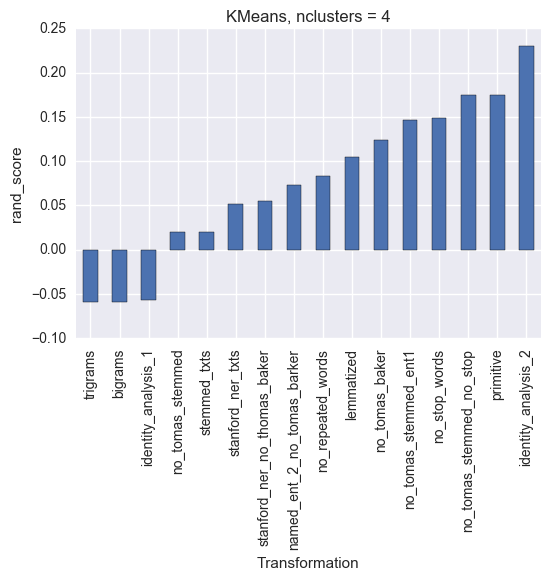

In [19]:
# Plot data corresponding to the 4clusters.csv file: KMeans
data_4_clusters_kmeans.rand_score = data_4_clusters_kmeans.rand_score.astype(float)
data_4_clusters_kmeans.cluster_split = data_4_clusters_kmeans.cluster_split.astype(float)
data_4_clusters_kmeans = data_4_clusters_kmeans.sort_values(by="rand_score")
ax_kmeans_4 = data_4_clusters_kmeans.plot(x='model', y='rand_score', kind='bar', 
                             title='KMeans, nclusters = 4', legend = False)
ax_kmeans_4.set_xlabel("Transformation")
ax_kmeans_4.set_ylabel("rand_score")

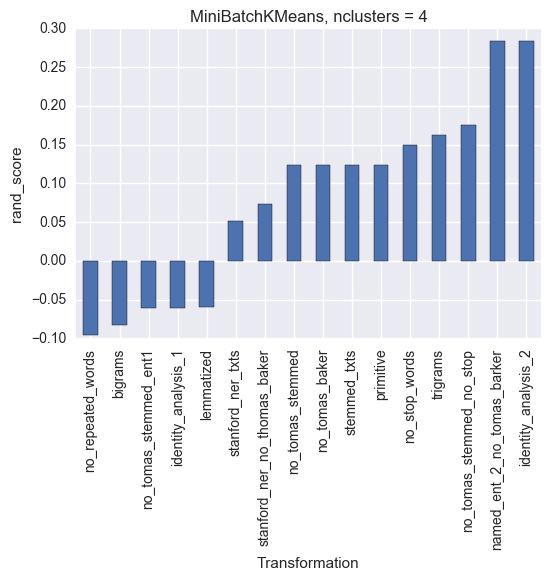

In [20]:
# Plot data corresponding to the 4clusters.csv file: MiniBatchKMeans
data_4_clusters_MBKM.rand_score = data_4_clusters_MBKM.rand_score.astype(float)
data_4_clusters_MBKM.cluster_split = data_4_clusters_MBKM.cluster_split.astype(float)
data_4_clusters_MBKM = data_4_clusters_MBKM.sort_values(by="rand_score")
ax_MBKM_4 = data_4_clusters_MBKM.plot(x='model', y='rand_score', kind='bar', 
                             title='MiniBatchKMeans, nclusters = 4', legend = False)
ax_MBKM_4.set_xlabel("Transformation")
ax_MBKM_4.set_ylabel("rand_score")

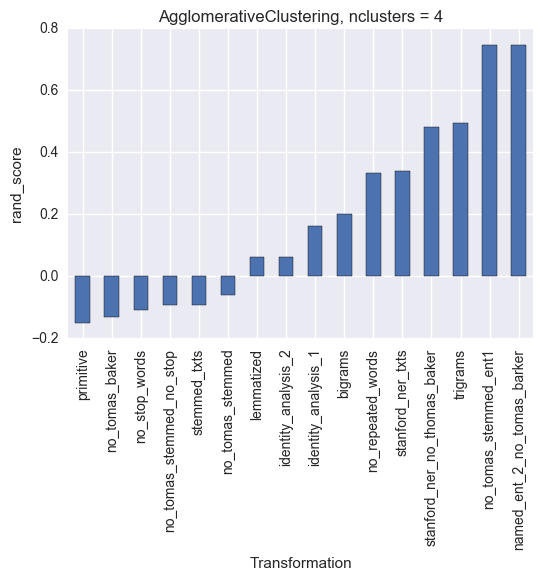

In [21]:
# Plot data corresponding to the 4clusters.csv file: AgglomerativeClustering
data_4_clusters_AC.rand_score = data_4_clusters_AC.rand_score.astype(float)
data_4_clusters_AC.cluster_split = data_4_clusters_AC.cluster_split.astype(float)
data_4_clusters_AC = data_4_clusters_AC.sort_values(by="rand_score")
ax_ac_4 = data_4_clusters_AC.plot(x='model', y='rand_score', kind='bar', 
                             title='AgglomerativeClustering, nclusters = 4', legend = False)
ax_ac_4.set_xlabel("Transformation")
ax_ac_4.set_ylabel("rand_score")

En primer lugar, cabe destacar la gran diferencia obtenida en función al algorítmo de clustering utilizado. El que da mejores resultados claramente es el de `AgglomerativeClustering`, y los resultados asociados al mismo serán, por tanto, los estudiados con mayor profundidad. Aquella representación con una peor puntuación corresponde a la `primitive`, que corresponde a los textos iniciales en los que no se ha aplicado ninguna transformación. Por otro lado, la transformación que obtiene la mejor puntuación, ~0.75 y por tanto cercana a 1, es la combinación de *Entidades nombradas NLTK* + *Exclusión del nombre Thomas Baker* (`named_ent_2_no_tomas_barker`). De entre todas las transformaciones unitarias, la que mejor resultados da es la de Trigramas (`trigrams`). Por otro lado, cabe destacar la alta no linealidad de la combinación de transformaciones. Por ejemplo, de los 4 mejores implican la combinación de la transformación *Exclusión del nombre Thomas Baker* (`no_tomas_baker`) con otra transformación diferente. Sin embargo, la transformación `no_tomas_baker` por si sola no parece aumentar en gran medida el resultado inicial. También cabe destacar la importancia de las transformaciones que implican el reconocimiento de entidades nombradas, ya que están presentes en aquellas transformaciones con mejores resultados.

### 6.2. Evaluación de los resultados: número de clústers variable (1-10)

En el presente apartado se analizan los resultados obtenidos en la Sección 5.4. En ella, se ha considerado el efecto de cada una de las transformaciones incluidas en las Secciones 4.1 y 4.2 pero teniendo en cuenta un número variable de clústers, de 1 a 10. Los presentes resultados se centran en el algorítmo de clustering `AgglomerativeClustering`, ya que como se ha visto en el apartado anterior, es el que mejor resultado arroja. En la siguiente figura, se grafica el `rand_score` de cada una de las transformaciones consideradas, teniendo en cuenta dos criterios: un número de clústers igual a 4 (`n_4`, sombreado en azul), y el mejor resultado obtenido en cada caso para los 10 números de clústers considerados (`n_variable`, sombreado en verde). Como se puede observar, para ciertas transformaciones (por ejemlo `named_ent_2_no_tomas_barker` y `no_tomas_stemmed_ent1`), en ambos casos se obtiene un resultado parecido. Sin embargo, en otras ocasiones, por ejemplo para la transformación `no_repeated_words`, se logra una mejora notable en el resultado si el número de clústers no se fija de antemano. De hecho, la aplicación de dicha transformación junto con el hecho de no fijar en número de clusters arroja el mejor resultado de todo el estudio. Dado que en el problema estudiado en la presente práctica se conoce el número real de clústers, puede que lo más apropiado sea hacer uso del mismo. Sin embargo, en muchas ocasiones, puede ser que averiguar el número de clústers sea precisamente una de las partes más importantes del problema. En dichos casos, el análisis realizado en la presente sección puede ser muy relevante.

In [32]:
data_n_clusters = pd.read_csv('CSV_output/bestclusters.csv')
data_n_clusters_AC = data_n_clusters.loc[data_n_clusters.clustering_mode == "AgglomerativeClustering"]
list_data = []
index = []
fil_keys = {"real":"n_4", "best":"n_variable"}
comp_modes = data_n_clusters_AC.comparing_mode.unique()
for model in data_n_clusters_AC.model.unique():
    curr_data = {}
    for mode in comp_modes:
        value = data_n_clusters_AC[(data_n_clusters_AC["model"]==model) 
                                   & (data_n_clusters_AC["comparing_mode"]==mode)]["rand_score"].values[0]
        curr_data[fil_keys[mode]] = value
    list_data.append(curr_data)
    index.append(model)

new_df = pd.DataFrame(list_data, index=index)
new_df = new_df.iloc[::-1]
new_df[['n_4','n_variable']] = new_df[['n_4','n_variable']].apply(pd.to_numeric)

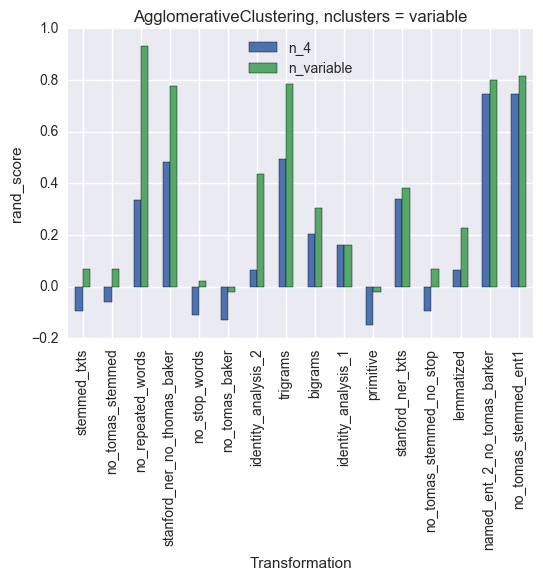

In [33]:
ax_AC_n = new_df.plot(kind="bar", title='AgglomerativeClustering, nclusters = variable')
ax_AC_n.set_xlabel("Transformation")
ax_AC_n.set_ylabel("rand_score")

## 7. Conclusiones

En la presente práctica, se han analizado 19 textos pertenecientes a 4 personas diferentes llamadas todas ellas *Thomas Barker*. El objetivo principal de la práctica era agrupar los textos utilizando diferentes algorítmos de clustering, estudiando el effecto de aplicar diversas transformaciones sobre los mismos, comparando los resultados con el resultado real (conocido de antemano). Respecto a los algorítmos de clustering, se ha comprobado que el que mejor resultados arroja es el de `AgglomerativeClustering`, de la librería de `Python` `scikit-learn`. Respecto a las transformaciones, se ha comprobado que aquellas que mejor funcionan suelen ser resultado de combinar el reconocimiento de entidades nombradas así como la exclusión del nombre *Thomas Barker*. Por otro lado, mientras que dos transformaciones individuales pueden no mejorar de manera notable el resultado, ambas combinadas pueden llegar a dar muy buenos resultados. Se considera por tanto que la combinación de transformaciones es altamente no lineal y por tanto es dificil en ocasiones predecir cual va a ser el efecto final. Finalmente, también se ha estudiado el efecto de variar el número de clústers, pudiéndose obtener grandes diferencias en comparación con el caso cuando el número de clústers se deja fijo.

Respecto a la aportación de cada uno de los alumnos responsables de la presente práctica (*Ignacio Arias Barra y Raúl Sánchez Martín*), se considera que ambos han colaborado de manera igual durante todos los procesos de la misma: diseño inicial, planteamiento e implementación de las transformaciones tenidas en cuenta, ejecución del código principal, análisis de los resultados y redacción de la memoria.